In [1]:
import pandas as pd
import numpy as np

path = 'E:/BaiduYunDownload/DC_2/'
data = pd.read_csv(path+'data0219.csv',encoding = 'gb18030',index_col=None)
data = data.fillna(-1)

D:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
for index,i in enumerate(data.columns):
    if 'cost_sum' in i:
        data[i+str(index)] = data[i]/data['costpos_sum']
for index,i in enumerate(data.columns):
    if 'count' in i:
        data[i+str(index)] = data[i]/data['costpos_count']

In [3]:
from sklearn import metrics
from sklearn import cross_validation
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from imblearn.over_sampling import RandomOverSampler

train_data = data[data['TT']=='train']
x = train_data.drop(['TT','student_id','grant_amount','class_rank'],axis = 1)
y = train_data['grant_amount']

test_data = data[data['TT']=='test']
test_x = test_data.drop(['TT','student_id','grant_amount','class_rank'],axis = 1)
test_y = test_data['grant_amount']

os =  RandomOverSampler(ratio=1.0)
X_overs, y_overs = os.fit_sample(x, y)

data_train, data_test, target_train, target_test = cross_validation.train_test_split(X_overs, y_overs)

D:\Anaconda2\lib\site-packages\scikit_learn-0.18.1-py2.7-win-amd64.egg\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\scikit_learn-0.18.1-py2.7-win-amd64.egg\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
xgb1 = XGBClassifier(
 learning_rate =0.02,
 n_estimators=820,
 max_depth=3,
 min_child_weight=0.5,
 gamma = 0.01,
 subsample=0.7,
 colsample_bytree=0.7,
 colsample_bylevel=0.6,
 objective= 'multi:softmax',
 seed = 10,
 nthread=8,
)

xgb1.fit(data_train, target_train,eval_metric='auc')    

train_pred = xgb1.predict(data_test)
    
print "\nModel Report"
#print "AUC : %.4g" % metrics.roc_auc_score(target_test, dtrain_predprob)
print "f1 : %.4g" % metrics.f1_score(target_test, train_pred,average = 'macro')


Model Report
f1 : 0.9317


In [8]:
y_pred = xgb1.predict(test_x)
submission = pd.DataFrame()
submission['studentid']  = test_data['student_id']
submission['subsidy'] = y_pred

submission['studentid'] = submission['studentid'].astype(int)
submission['subsidy'] = submission['subsidy'].astype(int)
submission.to_csv(path+'result0220.csv',sep = ',', index=False)

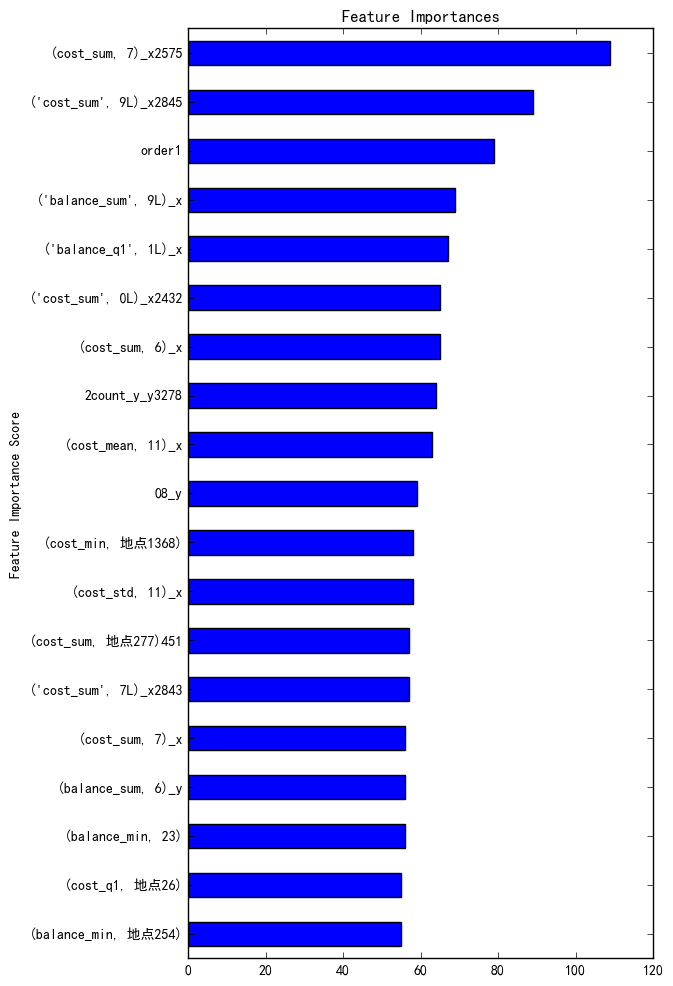

In [7]:
import  matplotlib.pyplot as plt  
%matplotlib inline
###画图显示中文
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

feat_imp = pd.Series(xgb1.booster().get_fscore()).sort_values(ascending=True)
feat_imp[-20:-1].plot(kind='barh', title='Feature Importances',figsize=(6,12))
plt.ylabel('Feature Importance Score')